# Hyperparameter Tuning {#sec-hyperparameter-tuning}

Hyperparameter tuning is an important, but often difficult and computationally intensive task.
Changing the architecture of a neural network or the learning rate of an optimizer can have a significant impact on the performance.

The goal of hyperparameter tuning is to optimize the hyperparameters in a way that improves the performance of the machine learning or deep learning model.
The simplest, but also most computationally expensive, approach uses manual search (or trial-and-error [@Meignan:2015vp]).
Commonly encountered is simple random search, i.e., random and repeated selection of hyperparameters for evaluation, and lattice search ("grid search").
In addition, methods that perform directed search  and other model-free algorithms, i.e., algorithms that do not explicitly rely on a model, e.g., evolution strategies [@Bart13j] or pattern search [@Torczon00] play an important role.
Also, "hyperband", i.e., a multi-armed bandit strategy that dynamically allocates resources to a set of random configurations and uses successive bisections to stop configurations with poor performance [@Li16a], is very common in hyperparameter tuning.
The most sophisticated and efficient approaches are the Bayesian optimization and surrogate model based optimization methods, which are based on the optimization of cost functions determined by simulations or experiments.

We consider below a surrogate model based optimization-based hyperparameter tuning approach based on the Python version of the SPOT ("Sequential Parameter Optimization Toolbox") [@BLP05], which is suitable for situations where only limited resources are available. This may be due to limited availability and cost of hardware, or due to the fact that confidential data may only be processed locally, e.g., due to legal requirements.
Furthermore, in our approach, the understanding of algorithms is seen as a key tool for enabling transparency and explainability. This can be enabled, for example, by quantifying the contribution of machine learning and deep learning components (nodes, layers, split decisions, activation functions, etc.).
Understanding the importance of hyperparameters and the interactions between multiple hyperparameters plays a major role in the interpretability and explainability of machine learning models.
SPOT provides statistical tools for understanding hyperparameters and their interactions. Last but not least, it should be noted that the SPOT software code is available in the open source `spotPython` package on github^[[https://github.com/sequential-parameter-optimization](https://github.com/sequential-parameter-optimization)], allowing replicability of the results.
This tutorial descries the Python variant of SPOT, which is called `spotPython`. The R implementation is described in @bart21i.
SPOT is an established open source software that has been maintained for more than 15 years [@BLP05] [@bart21i].

This tutorial is structured as follows. The concept of the hyperparameter tuning software `spotPython` is described in @sec-spot. 
@sec-hyperparameter-tuning-for-pytorch describes the integration of `spotPython` into the ``PyTorch`` training workflow in detail and presents the results.
Finally, @sec-summary presents a summary and an outlook.


# The Hyperparameter Tuning Software SPOT {#sec-spot}

Surrogate model based optimization methods are common approaches in simulation and optimization. SPOT was developed because there is a great need for sound statistical analysis of simulation and optimization algorithms. SPOT includes methods for tuning based on classical regression and analysis of variance techniques.
It presents tree-based models such as classification and regression trees and random forests as well as Bayesian optimization (Gaussian process models, also known as Kriging). Combinations of different meta-modeling approaches are possible. SPOT comes with a sophisticated surrogate model based optimization method, that can handle discrete and continuous inputs. Furthermore, any model implemented in `scikit-learn` can be used out-of-the-box as a surrogate in `spotPython`.

SPOT implements key techniques such as exploratory fitness landscape analysis and sensitivity analysis. It can be used to understand the performance of various algorithms, while simultaneously giving insights into their algorithmic behavior.
In addition, SPOT can be used as an optimizer and for automatic and interactive tuning. Details on SPOT and its use in practice are given by @bart21i.

A typical hyperparameter tuning process with `spotPython` consists of the following steps:

1. Loading the data (training and test datasets), see @sec-data-loading.
2. Specification of the preprocessing model, see @sec-specification-of-preprocessing-model. This model is called `prep_model` ("preparation" or pre-processing).
The information required for the hyperparameter tuning is stored in the dictionary `fun_control`. Thus, the information needed for the execution of the hyperparameter tuning is available in a readable form.
3. Selection of the machine learning or deep learning model to be tuned, see @sec-selection-of-the-algorithm. This is called the `core_model`. Once the `core_model` is defined, then the associated hyperparameters are stored in the `fun_control` dictionary. First, the hyperparameters of the `core_model` are initialized with the default values of the `core_model`.
As default values we use the default values contained in the `spotPython` package for the algorithms of the `torch` package.
4. Modification of the default values for the hyperparameters used in `core_model`, see @sec-modification-of-default-values. This step is optional.
   1. numeric parameters are modified by changing the bounds.
   2. categorical parameters are modified by changing the categories ("levels").
5. Selection of target function (loss function) for the optimizer, see @sec-selection-of-target-function.
6. Calling SPOT with the corresponding parameters, see @sec-call-the-hyperparameter-tuner. The results are stored in a dictionary and are available for further analysis.
7. Presentation, visualization and interpretation of the results, see @sec-results-tuning.

# Hyperparameter Tuning for PyTorch With `spotPython`: Regression {#sec-hyperparameter-tuning-for-pytorch}

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch`
training workflow.

This document refers to the following software versions:

- ``python``: 3.10.10
- ``torch``: 2.0.1
- ``torchvision``: 0.15.0
- ``spotPython``: 0.2.15

`spotPython` can be installed via pip^[Alternatively, the source code can be downloaded from gitHub: [https://github.com/sequential-parameter-optimization/spotPython](https://github.com/sequential-parameter-optimization/spotPython).].

```{raw}
!pip install spotPython
```

## Setup {#sec-setup}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size and the device that is used.

In [1]:
MAX_TIME = 10
INIT_SIZE = 20
DEVICE = "cpu" # "cuda:0"

In [2]:
#| echo: false
import os
import copy
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '24-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

24-torch_p040025_10min_20init_2023-06-07_17-03-55


## Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process. This dictionary is called `fun_control` and is initialized with the function `fun_control_init`. The function `fun_control_init` returns a skeleton  dictionary. The dictionary is filled with the required information for the hyperparameter tuning process. It stores the hyperparameter tuning settings, e.g., the deep learning network architecture that should be tuned, the classification (or regression) problem, and the data that is used for the tuning.
The dictionary is used as an input for the SPOT function.

In [3]:
#| echo: true
from spotPython.utils.init import fun_control_init
fun_control = fun_control_init(task="regression",
 tensorboard_path="runs/24_spot_torch_regression")

## PyTorch Data Loading {#sec-data-loading}

In [4]:
# Create dataset
import pandas as pd
import numpy as np
from sklearn import datasets as sklearn_datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X, y = sklearn_datasets.make_regression(
    n_samples=1000, n_features=10, noise=1, random_state=123)
y = y.reshape(-1, 1)

# Normalize the data
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# combine the features and target into a single dataframe named train_df
train_df = pd.DataFrame(np.hstack((X_scaled, y_scaled)))

target_column = "y"
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column,
    axis=1), 
    train_df[target_column],                                                    random_state=42,
    test_size=0.25)
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)

(1000, 11)
(750, 11)
(250, 11)


In [5]:
import torch
from spotPython.torch.dataframedataset import DataFrameDataset
dtype_x = torch.float32
dtype_y = torch.float32
train_df = DataFrameDataset(train_df, target_column=target_column,
    dtype_x=dtype_x, dtype_y=dtype_y)
train = DataFrameDataset(trainset, target_column=target_column,
    dtype_x=dtype_x, dtype_y=dtype_y)
test = DataFrameDataset(testset, target_column=target_column,
    dtype_x=dtype_x, dtype_y=dtype_y)
n_samples = len(train)

* Now we can test the data loading:

In [6]:
from spotPython.torch.traintest import create_train_val_data_loaders
trainloader, testloader = create_train_val_data_loaders(train, 2, True, 0)
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    print(inputs)
    print(labels)
    break

torch.Size([2, 10])
torch.Size([2])
tensor([[0.6215, 0.5893, 0.4116, 0.6188, 0.5253, 0.7296, 0.3282, 0.5687, 0.6433,
         0.3343],
        [0.6944, 0.6985, 0.6626, 0.6258, 0.3584, 0.6016, 0.4559, 0.5058, 0.5325,
         0.3195]])
tensor([0.7143, 0.6457])


* Since this works fine, we can add the data loading to the `fun_control` dictionary:

In [7]:
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column,})

## Specification of the Preprocessing Model {#sec-specification-of-preprocessing-model}

After the training and test data are specified and added to the `fun_control` dictionary, `spotPython` allows the specification of a data preprocessing pipeline, e.g., for the scaling of the data or for the one-hot encoding of categorical variables. The preprocessing model is called `prep_model` ("preparation" or pre-processing) and includes steps that are not subject to the hyperparameter tuning process. The preprocessing model is specified in the `fun_control` dictionary. The preprocessing model can be implemented as a `sklearn` pipeline. The following code shows a typical preprocessing pipeline:

```{raw}
categorical_columns = ["cities", "colors"]
one_hot_encoder = OneHotEncoder(handle_unknown="ignore",
                                    sparse_output=False)
prep_model = ColumnTransformer(
        transformers=[
             ("categorical", one_hot_encoder, categorical_columns),
         ],
         remainder=StandardScaler(),
     )
```

In [8]:
#| echo: true
fun_control.update({"prep_model": None})

## Select `algorithm` and `core_model_hyper_dict` {#sec-selection-of-the-algorithm}

### Implementing a Configurable Neural Network With spotPython {#sec-implementation-with-spotpython}

`spotPython` includes the `Net_lin_reg` class which is implemented in the file `netregression.py`.

```{raw}
from torch import nn
import spotPython.torch.netcore as netcore


class Net_lin_reg(netcore.Net_Core):
    def __init__(
        self, _L_in, _L_out, l1, dropout_prob, lr_mult,
        batch_size, epochs, k_folds, patience, optimizer,
        sgd_momentum
    ):
        super(Net_lin_reg, self).__init__(
            lr_mult=lr_mult,
            batch_size=batch_size,
            epochs=epochs,
            k_folds=k_folds,
            patience=patience,
            optimizer=optimizer,
            sgd_momentum=sgd_momentum,
        )
        l2 = max(l1 // 2, 4)
        self.fc1 = nn.Linear(_L_in, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, _L_out)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob / 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

```

#### The `Net_Core` class

`Net_lin_reg` inherits from the class `Net_Core` which is implemented in the file `netcore.py`.  It implements the additional attributes that are common to all neural network models. The `Net_Core` class is implemented in the file `netcore.py`. It implements hyperparameters as attributes, that are not used by the `core_model`, e.g.:

* optimizer (`optimizer`),
* learning rate (`lr`),
* batch size (`batch_size`),
* epochs (`epochs`),
* k_folds (`k_folds`), and
* early stopping criterion "patience" (`patience`).

Users can add further attributes to the class. The class `Net_Core` is shown below.

```{raw}
from torch import nn


class Net_Core(nn.Module):
    def __init__(self, lr_mult, batch_size, epochs, k_folds, patience,
    optimizer, sgd_momentum):
        super(Net_Core, self).__init__()
        self.lr_mult = lr_mult
        self.batch_size = batch_size
        self.epochs = epochs
        self.k_folds = k_folds
        self.patience = patience
        self.optimizer = optimizer
        self.sgd_momentum = sgd_momentum
```

:::{.callout-note}


We see that the class `Net_lin_reg` has additional attributes and does not inherit from `nn` directly. It adds an additional class, `Net_core`, that takes care of additional attributes that are common to all neural network models, e.g., the learning rate multiplier `lr_mult` or the batch size `batch_size`.

`spotPython`'s `core_model` implements an instance of the `Net_lin_reg` class. In addition to the basic neural network model, the `core_model` can use these additional attributes.
`spotPython` provides methods for handling these additional attributes to guarantee 100% compatibility with the `PyTorch` classes. The method `add_core_model_to_fun_control` adds the hyperparameters and additional attributes to the `fun_control` dictionary. The method is shown below.

In [9]:
#| echo: true
from spotPython.torch.netregression import Net_lin_reg
from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
core_model = Net_lin_reg
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

## The Search Space {#sec-search-space}

### Configuring the Search Space With spotPython {#sec-configuring-the-search-space-with-spotpython}

#### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses `JSON` files for the specification of the hyperparameters.
Users can specify their individual `JSON` files, or they can use the `JSON` files provided by `spotPython`.
The `JSON` file for the `core_model` is called `torch_hyper_dict.json`.

`spotPython` can handle numerical, boolean, and categorical hyperparameters. They can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below.
Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

The corresponding entries for the `Net_lin_reg` class are shown below.

```json
    "Net_lin_reg":
    {
        "_L_in": {
            "type": "int",
            "default": 10,
            "transform": "None",
            "lower": 10,
            "upper": 10},
        "_L_out": {
            "type": "int",
            "default": 1,
            "transform": "None",
            "lower": 1,
            "upper": 1},
        "l1": {
            "type": "int",
            "default": 3,
            "transform": "transform_power_2_int",
            "lower": 3,
            "upper": 8},
        "dropout_prob": {
            "type": "float",
            "default": 0.01,
            "transform": "None",
            "lower": 0.0,
            "upper": 0.9},
        "lr_mult": {
            "type": "float",
            "default": 1.0,
            "transform": "None",
            "lower": 0.1,
            "upper": 10.0},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 4,
            "upper": 9},
        "k_folds": {
            "type": "int",
            "default": 1,
            "transform": "None",
            "lower": 1,
            "upper": 1},
        "patience": {
            "type": "int",
            "default": 2,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 5
        },
        "optimizer": {
            "levels": ["Adadelta",
                       "Adagrad",
                       "Adam",
                       "AdamW",
                       "SparseAdam",
                       "Adamax",
                       "ASGD",
                       "NAdam",
                       "RAdam",
                       "RMSprop",
                       "Rprop",
                       "SGD"],
            "type": "factor",
            "default": "SGD",
            "transform": "None",
            "class_name": "torch.optim",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 12},
        "sgd_momentum": {
            "type": "float",
            "default": 0.0,
            "transform": "None",
            "lower": 0.0,
            "upper": 1.0}
    },
```


## Modifying the Hyperparameters {#sec-modification-of-hyperparameters}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. These functions are described in the following.

### Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-default-values}

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a simple rule for de-activating hyperparameters: If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.


### Modify Hyperparameters of Type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the `PyTorch` tutorial, it is de-activated here by setting the lower and upper bound to the same value. Note, `k_folds` is of type "integer".

In [10]:
#| echo: true
# modify the hyperparameter levels

from spotPython.hyperparameters.values import modify_hyper_parameter_bounds

fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[2, 16])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[3, 7])

### Modify Hyperparameter of Type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified.
New configurations can be chosen by adding or deleting levels. For example, the hyperparameter `optimizer` can be re-configured as follows:

In the following setting, two optimizers (`"SGD"` and `"Adam"`) will be compared during the `spotPython` hyperparameter tuning. The hyperparameter `optimizer` is active.

In [11]:
#| echo: true
from spotPython.hyperparameters.values import modify_hyper_parameter_levels
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",
    ["SGD", "Adam"])

The hyperparameter `optimizer` can be de-activated by choosing only one value (level), here: `"SGD"`.

In [12]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD"])

As discussed in @sec-optimizers, there are some issues with the LBFGS optimizer. Therefore, the usage of the LBFGS optimizer is not  deactivated in `spotPython` by default. However, the LBFGS optimizer can be activated by adding it to the list of optimizers.
`Rprop`  was removed, because it does perform very poorly (as some pre-tests have shown). However, it can also be activated by adding it to the list of optimizers.
Since `SparseAdam` does not support dense gradients, `Adam` was used instead.
Therefore, there are 10 default optimizers:

In [13]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",
    ["Adadelta", "Adagrad", "Adam", "AdamW", "Adamax", "ASGD", "NAdam"])


fun_control.update({
               "_L_in": n_features,
               "_L_out": 1,})

### Optimizers {#sec-optimizers}

@tbl-optimizers shows some of the optimizers available in `PyTorch`:

| Optimizer | lr  | mom | weight | damp | nest | rho | lr_sc | lr_decay | betas | lambd | alpha | mom_decay | etas | step_s|
| :-------    |:--- |:--- | :---   | :--- | :--- |:--- | :---  | :---     | :---- |:----  |:----  | :----     | :--- | :--- |
| Adadelta  | -   | -   |  0.    | -    | -    | 0.9 | 1.0   | -        | -     | -     |-      |    -      |   -  | -    |
| Adagrad   |1e-2 | -   | 0.     | -    | -    | -   | -     | 0.       | -     | -     |-      | -         |   -  | -    |
| Adam      |1e-3 | -   | 0.     | -    | -    | -   | -     | -        |(0.9,0.999)| - |-      |   -       |   -  | -    |
| AdamW     |1e-3 | -   | 1e-2   | -    | -    | -   | -     | -        |(0.9,0.999)| - |  -    |       -   |   -  | -    |
| SparseAdam | 1e-3| -  | -      | -    | -    | -   | -     | -        |(0.9,0.999)|-  |-      | -         |   -  | -    |
| Adamax | 2e-3    | -  | 0.     | -    | -    | -   | -     | -        |(0.9, 0.999)|- |-      | -         |   -  | -    |
| ASGD   | 1e-2 |  0.9  | 0.     | -    | False| -   | -     | -        | -        |1e-4| 0.75  |  -        |  -   | -    |
| LBFGS |  1.   | -     | -      | -    | -    | -   | -     | -        | -        | -  |-      | -         |  -   |   -  |
| NAdam | 2e-3  | -     | 0.     | -    | -    | -   | -     | -        |(0.9,0.999)| - |-      | 0         |   -  | -    |
| RAdam | 1e-3  | -     | 0.     | -    | -    | -   | -     | -        |(0.9,0.999)| - |-      | -         |   -  | -    |
| RMSprop | 1e-2| 0. |   0.      |  -   | -    | -   | -     | -        |(0.9,0.999)| - |-      | -         |   -  | -    |
| Rprop |  1e-2 | -  | -         | -    | -    | -   | -     | -        | -         | -| (0.5,1.2)| (1e-6, 50)| -   | -   |
| SGD   | required | 0.| 0.      | 0.   | False | -  | -     | -        | -         |- |-       | -         |   -  | -    |

: Optimizers available in PyTorch (selection). "mom" denotes `momentum`, "weight" `weight_decay`, "damp" `dampening`, "nest" `nesterov`,  "lr_sc" `learning rate for scaling delta`, "mom_dec" for `momentum_decay`, and "step_s" for `step_sizes`.  The default values are shown in the table. {#tbl-optimizers}

`spotPython` implements an `optimization` handler that maps the optimizer names to the corresponding `PyTorch` optimizers.

::: {.callout-note}
### A note on LBFGS

We recommend deactivating `PyTorch`'s LBFGS optimizer, because it does not perform very well. The  `PyTorch` documentation, see [https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS), states:

> This is a very memory intensive optimizer (it requires additional `param_bytes * (history_size + 1)` bytes). If it doesn’t fit in memory try reducing the history size, or use a different algorithm.


Furthermore, the LBFGS optimizer is not compatible with the `PyTorch` tutorial. The reason is that the LBFGS optimizer requires the `closure` function, which is not implemented in the `PyTorch` tutorial. Therefore, the `LBFGS` optimizer is recommended here.
:::

Since there are 10 optimizers in the portfolio, it is not recommended tuning the hyperparameters that effect one single optimizer only.

::: {.callout-note}
#### A note on the learning rate
`spotPython` provides a multiplier for the default learning rates, `lr_mult`, because optimizers use different learning rates. Using a multiplier for the learning rates might enable a simultaneous tuning of the learning rates for all optimizers. However, this is not recommended, because the learning rates are not comparable across optimizers. Therefore, we recommend fixing the learning rate for all optimizers if multiple optimizers are used. This can be done by setting the lower and upper bounds of the learning rate multiplier to the same value as shown below.
:::

Thus, the learning rate, which affects the `SGD` optimizer, will be set to a fixed value. We choose the default value of `1e-3` for the learning rate, because it is used in other `PyTorch` examples (it is also the default value used by `spotPython` as defined in the `optimizer_handler()` method). We recommend tuning the learning rate later, when a reduced set of optimizers is fixed.
Here, we will demonstrate how to select in a screening phase the optimizers that should be used for the hyperparameter tuning.

For the same reason, we will fix the `sgd_momentum` to `0.9`. 

In [14]:
#| echo: true
fun_control = modify_hyper_parameter_bounds(fun_control,
    "lr_mult", bounds=[1e-3, 1e-3])
fun_control = modify_hyper_parameter_bounds(fun_control,
    "sgd_momentum", bounds=[0.9, 0.9])

## Evaluation  {#sec-selection-of-target-function}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set and
2. the loss function (and a metric).

### Hold-out Data Split and Cross-Validation

As a default, `spotPython` provides a standard hold-out data split and cross validation.

#### Hold-out Data Split

If a hold-out data split is used, the data will be partitioned into a training, a validation, and a test data set.
The split depends on the setting of the `eval` parameter. If `eval` is set to `train_hold_out`, one data set, usually the original training data set, is split into a new training and a validation data set. The training data set is used for training the model. The validation data set is used for the evaluation of the hyperparameter configuration and early stopping to prevent overfitting. In this case, the original test data set is not used.
The following splits are performed in the hold-out setting:
$\{\text{train}_0, \text{test}\} \rightarrow \{\text{train}_1, \text{validation}_1, \text{test}\}$, where $\text{train}_1 \cup \text{validation}_1 = \text{train}_0$.


::: {.callout-note}
`spotPython` returns the hyperparameters of the machine learning and deep learning models, e.g., number of layers, learning rate, or optimizer, but not the model weights. Therefore, after the SPOT run is finished, the corresponding model with the optimized architecture has to be trained again with the best hyperparameter configuration. The training is performed on the training data set. The test data set is used for the final evaluation of the model.

Summarizing, the following splits are performed in the hold-out setting:

1. Run `spotPython` with `eval` set to `train_hold_out` to determine the best hyperparameter configuration.
2. Train the model with the best hyperparameter configuration ("architecture")  on the training data set:
   * `train_tuned(model_spot, train, "model_spot.pt")`.
3. Test the model on the test data:
   * `test_tuned(model_spot, test, "model_spot.pt")`

These steps will be exemplified in the following sections.
:::

In addition to this `hold-out` setting, `spotPython` provides another hold-out setting, where an explicit test data is specified by the user that will be used as the validation set. To choose this option, the `eval` parameter is set to `test_hold_out`. In this case, the training data set is used for the model training. Then, the explicitly defined test data set is used for the evaluation of the hyperparameter configuration (the validation).

#### Cross-Validation

The cross validation setting is used by setting the `eval` parameter to `train_cv` or `test_cv`. In both  cases, the data set is split into $k$ folds. The model is trained on $k-1$ folds and evaluated on the remaining fold. This is repeated $k$ times, so that each fold is used exactly once for evaluation. The final evaluation is performed on the test data set. The cross validation setting is useful for small data sets, because it allows to use all data for training and evaluation. However, it is computationally expensive, because the model has to be trained $k$ times.

::: {.callout-note}
Combinations of the above settings are possible, e.g., cross validation can be used for training and hold-out for evaluation or *vice versa*. Also, cross validation can be used for training and testing. Because cross validation is not used in the `PyTorch` tutorial [@pyto23a], it is not considered further here.
:::

#### Overview of the Evaluation Settings

##### Settings for the Hyperparameter Tuning

@tbl-eval-settings provides an overview of the training evaluations.

| `eval` | `train` | `test` | function | comment |
| --- | :-: | :-: | :----- | :----- |
| `"train_hold_out"` | $\checkmark$ |  |  `train_one_epoch()`, `validate_one_epoch()` for early stopping|  splits the `train` data set internally|
| `"test_hold_out"` | $\checkmark$ | $\checkmark$ | `train_one_epoch()`, `validate_one_epoch()` for early stopping  |use the `test data set` for `validate_one_epoch()` |
| `"train_cv"` | $\checkmark$ |              |  `evaluate_cv(net, train)`  | CV using the  `train` data set |
| `"test_cv"` |               | $\checkmark$ |  `evaluate_cv(net, test)` | CV using the  `test` data set . Identical to `"train_cv"`, uses only test data.|
: Overview of the evaluation settings. {#tbl-eval-settings}

* `"train_cv"` and `"test_cv"` use `sklearn.model_selection.KFold()` internally.


#### Settings for the Final Evaluation of the Tuned Architecture

##### Training of the Tuned Architecture
`train_tuned(model, train)`: train the model with the best hyperparameter configuration (or simply the default) on the training data set. It splits the `train`data into new `train` and `validation` sets using  `create_train_val_data_loaders()`, which calls `torch.utils.data.random_split()` internally. Currently, 60% of the data is used for training and 40% for validation. The `train` data is used for training the model with `train_one_epoch()`. The `validation` data is used for early stopping using `validate_one_epoch()` on the `validation` data set.

##### Testing of the Tuned Architecture

`test_tuned(model, test)`: test the model on the test data set. No data splitting is performed. The (trained) model is evaluated using the `validate_one_epoch()` function.

Note: During training, `shuffle` is set to `True`, whereas during testing, `shuffle` is set to `False`.


### Loss Functions and Metrics

The key `"loss_function"` specifies the loss function which is used during the optimization. There are several different loss functions under `PyTorch`'s `nn` package. For example, a simple loss is `MSELoss`, which computes the mean-squared error between the output and the target. In this tutorial we will use `CrossEntropyLoss`, because it is also used in the `PyTorch` tutorial.

#### Loss Function

The loss function is specified by the key `"loss_function"`.
We will use MSE loss for the regression task.

In [15]:
#| echo: true
from torch.nn import MSELoss
loss_torch = MSELoss()
fun_control.update({"loss_function": loss_torch})

In addition to the loss functions, `spotPython` provides access to a large number of metrics.

* The key `"metric_sklearn"` is used for metrics that follow the `scikit-learn` conventions.
* The key `"river_metric"` is used for the river based evaluation [@mont20a] via `eval_oml_iter_progressive`, and 
* the key `"metric_torch"` is used for the metrics from `TorchMetrics`. 

`TorchMetrics` is a collection of more than 90 PyTorch metrics^[[https://torchmetrics.readthedocs.io/en/latest/.](https://torchmetrics.readthedocs.io/en/latest/)].

In [16]:
#| echo: true
from torchmetrics import MeanAbsoluteError
metric_torch = MeanAbsoluteError()
fun_control.update({"metric_torch": metric_torch})

## Calling the SPOT Function {#sec-call-the-hyperparameter-tuner}

In [17]:
#| echo: false
# extract the variable types, names, and bounds
from spotPython.hyperparameters.values import (get_bound_values,
    get_var_name,
    get_var_type,)
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` generates a design table as follows:

In [18]:
#| echo: true
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name         | type   | default   |   lower |   upper | transform             |
|--------------|--------|-----------|---------|---------|-----------------------|
| _L_in        | int    | 10        |  10     |  10     | None                  |
| _L_out       | int    | 1         |   1     |   1     | None                  |
| l1           | int    | 3         |   3     |   8     | transform_power_2_int |
| dropout_prob | float  | 0.01      |   0     |   0.9   | None                  |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 | None                  |
| batch_size   | int    | 4         |   1     |   4     | transform_power_2_int |
| epochs       | int    | 4         |   2     |  16     | transform_power_2_int |
| k_folds      | int    | 1         |   1     |   1     | None                  |
| patience     | int    | 2         |   3     |   7     | transform_power_2_int |
| optimizer    | factor | SGD       |   0     |   6     | None                  |
| sgd_momentum |

This allows to check if all information is available and if the information is correct.  @tbl-design shows the experimental design for the hyperparameter tuning. Hyperparameter transformations are shown in the column "transform", e.g., the `l1` default is `5`, which results in the value $2^5 = 32$ for the network, because the transformation ` transform_power_2_int` was selected in the `JSON` file. The default value of the `batch_size` is set to `4`, which results in a batch size of $2^4 = 16$. 


| name         | type   | default   |   lower |   upper | transform             |
|--------------|--------|-----------|---------|---------|-----------------------|
| _L_in        | int    | 10        |  10     |  10     | None                  |
| _L_out       | int    | 1         |   1     |   1     | None                  |
| l1           | int    | 3         |   3     |   8     | transform_power_2_int |
| dropout_prob | float  | 0.01      |   0     |   0.9   | None                  |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 | None                  |
| batch_size   | int    | 4         |   1     |   4     | transform_power_2_int |
| epochs       | int    | 4         |   2     |  16     | transform_power_2_int |
| k_folds      | int    | 1         |   1     |   1     | None                  |
| patience     | int    | 2         |   3     |   7     | transform_power_2_int |
| optimizer    | factor | SGD       |   0     |   6     | None                  |
| sgd_momentum | float  | 0.0       |   0.9   |   0.9   | None                  |

: Experimental design for the hyperparameter tuning. The table shows the hyperparameters, their types, default values, lower and upper bounds, and the transformation function. The transformation function is used to transform the hyperparameter values from the unit hypercube to the original domain. The transformation function is applied to the hyperparameter values before the evaluation of the objective function. {#tbl-design}

The objective function `fun_torch` is selected next. It implements an interface from `PyTorch`'s training, validation, and  testing methods to `spotPython`.

In [19]:
#| echo: true
from spotPython.fun.hypertorch import HyperTorch
fun = HyperTorch().fun_torch

In [20]:
#| echo: false
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

In [21]:
fun_control.update({
               "device": "cpu",
               })

The `spotPython` hyperparameter tuning is started by calling the `Spot` function. Here, we will run the tuner for approximately 30 minutes (`max_time`). Note: the initial design is always evaluated in the `spotPython` run. As a consequence, the run may take longer than specified by `max_time`, because the evaluation time of initial design (here: `init_size`, 10 points) is performed independently of `max_time`.

In [22]:
#| echo: true
from spotPython.spot import spot
from math import inf
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)


config: {'_L_in': 10, '_L_out': 1, 'l1': 64, 'dropout_prob': 0.4475780541539, 'lr_mult': 0.001, 'batch_size': 16, 'epochs': 512, 'k_folds': 1, 'patience': 32, 'optimizer': 'Adagrad', 'sgd_momentum': 0.9}
Epoch: 1
Loss on hold-out set: 0.2646102481766751
MeanAbsoluteError value on hold-out data: 0.4831759035587311
Epoch: 2
Loss on hold-out set: 0.26697668511616557
MeanAbsoluteError value on hold-out data: 0.4876554310321808
Epoch: 3
Loss on hold-out set: 0.2589440196752548
MeanAbsoluteError value on hold-out data: 0.4812147915363312
Epoch: 4
Loss on hold-out set: 0.2660453986180456
MeanAbsoluteError value on hold-out data: 0.4856504201889038
Epoch: 5
Loss on hold-out set: 0.2643739981086631
MeanAbsoluteError value on hold-out data: 0.4842057228088379
Epoch: 6
Loss on hold-out set: 0.261713013837212
MeanAbsoluteError value on hold-out data: 0.4832416772842407
Epoch: 7
Loss on hold-out set: 0.2631598820811824
MeanAbsoluteError value on hold-out data: 0.48207616806030273
Epoch: 8
Loss on 

During the run, the following output is shown:

```{raw}
config: {'_L_in': 10, '_L_out': 1, 'l1': 64, 'dropout_prob': 0.4475780541539,
    'lr_mult': 0.001, 'batch_size': 16, 'epochs': 512, 'k_folds': 1,
    'patience': 32,'optimizer': 'Adagrad', 'sgd_momentum': 0.9}
Epoch: 1
...
Epoch: 7002
Loss on hold-out set: 1.6959798782529844e-05
MeanAbsoluteError value on hold-out data: 0.0018855303060263395
Epoch: 7003
Loss on hold-out set: 1.6984027051769603e-05
MeanAbsoluteError value on hold-out data: 0.001883985591121018
Early stopping at epoch 7002
Returned to Spot: Validation loss: 1.6984027051769603e-05
```


## Tensorboard {#sec-tensorboard}


The textual output shown in the console (or code cell) can be visualized with Tensorboard.

### Tensorboard: Start Tensorboard

Start TensorBoard through the command line to visualize data you logged. 
Specify the root log directory as used in `fun_control = fun_control_init(task="regression", tensorboard_path="runs/24_spot_torch_regression")` as the `tensorboard_path`. The argument logdir points to directory where TensorBoard will look to find event files that it can display. TensorBoard will recursively walk the directory structure rooted at logdir, looking for .*tfevents.* files.

tensorboard --logdir=runs

Go to the URL it provides OR to http://localhost:6006/.

The following figures show some screenshots of Tensorboard.

![Tensorboard](./figures/tensorboard_0.png){#fig-tensorboard_0}

![Tensorboard](./figures/tensorboard_hdparams.png){#fig-tensorboard_hdparams}

![Tensorboard](./figures/tensorboard_parallel.png){#fig-tensorboard_parallel}



## Results {#sec-results-tuning}

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The following code generates the progress plot from @fig-progress.

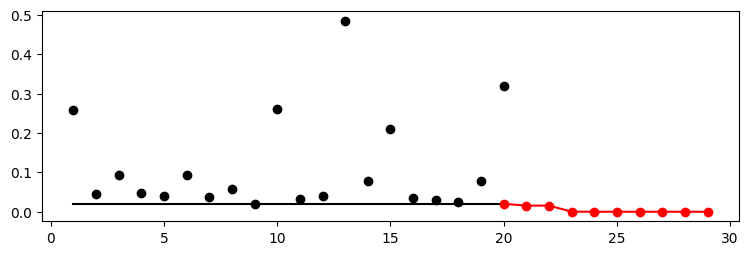

In [23]:
#| echo: true
spot_tuner.plot_progress(log_y=False, filename="./figures/" + experiment_name+"_progress.png")

![Progress plot. `Black` dots denote results from the initial design. `Red` dots  illustrate the improvement found by the surrogate model based optimization (surrogate model based optimization).](./figures/figures24-torch_bartz09_10min_20init_2023-06-06_22-50-23_progress.png){#fig-progress}

@fig-progress shows a typical behaviour that can be observed in many hyperparameter studies [@bart21i]: the largest improvement is obtained during the evaluation of the initial design. The surrogate model based optimization-optimization with the surrogate refines the results. @fig-progress also illustrates one major difference between `ray[tune]` as used in @pyto23a and `spotPython`: the `ray[tune]` uses a random search and will generate results similar to the *black* dots, whereas `spotPython` uses a surrogate model based optimization and presents results represented by *red* dots in @fig-progress. The surrogate model based optimization is considered to be more efficient than a random search, because the surrogate model guides the search towards promising regions in the hyperparameter space.

In addition to the improved ("optimized") hyperparameter values, `spotPython` allows a statistical analysis, e.g., a sensitivity analysis, of the results. We can print the results of the hyperparameter tuning, see @tbl-results.

In [24]:
#| echo: true
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |                 tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|-----------------------|-----------------------|--------------|---------|
| _L_in        | int    | 10        |    10.0 |    10.0 |                  10.0 | None                  |         0.00 |         |
| _L_out       | int    | 1         |     1.0 |     1.0 |                   1.0 | None                  |         0.00 |         |
| l1           | int    | 3         |     3.0 |     8.0 |                   7.0 | transform_power_2_int |        96.71 | ***     |
| dropout_prob | float  | 0.01      |     0.0 |     0.9 | 7.033278237589258e-09 | None                  |         0.09 |         |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 |                 0.001 | None                  |         0.00 |         |
| batch_size   | int    | 4         |     1.0 |     4.0 |                   2.0 | t

| name       | type   | default          |   lower |   upper |   tuned | transform             |   importance | stars   |
|------------|--------|-------------|---------:|---------:|---------:|--------------------|--------------:|---------|
| _L_in        | int    | 10        |    10.0 |    10.0 |    10.0 | None                  |         0.00 |         |
| _L_out       | int    | 1         |     1.0 |     1.0 |     1.0 | None                  |         0.00 |         |
| l1           | int    | 3         |     3.0 |     8.0 |     6.0 | power_2_int |         1.42 | *       |
| drop_p | float  | 0.01      |     0.0 |     0.9 |     0.0 | None                  |         0.00 |         |
| lr_mult      | float  | 1.0       |   0.001 |   0.001 |   0.001 | None                  |         0.00 |         |
| batch_s   | int    | 4         |     1.0 |     4.0 |     1.0 | power_2_int |         0.01 |         |
| epochs       | int    | 4         |     2.0 |    16.0 |    13.0 | power_2_int |       100.00 | ***     |
| k_folds      | int    | 1         |     1.0 |     1.0 |     1.0 | None                  |         0.00 |         |
| patience     | int    | 2         |     3.0 |     7.0 |     4.0 | power_2_int |         0.00 |         |
| optim    | factor | SGD       |     0.0 |     6.0 |     4.0 | None                  |         0.00 |         |
| sgd_mom | float  | 0.0       |     0.9 |     0.9 |     0.9 | None                  |         0.00 |         |
: Results of the hyperparameter tuning. The table shows the hyperparameters, their types, default values, lower and upper bounds, and the transformation function. The column "tuned" shows the tuned values. The column "importance" shows the importance of the hyperparameters. The column "stars" shows the importance of the hyperparameters in stars. The importance is computed by the SPOT software. {#tbl-results}

To visualize the most important hyperparameters, `spotPython` provides the function `plot_importance`. The following code generates the importance plot from @fig-importance.

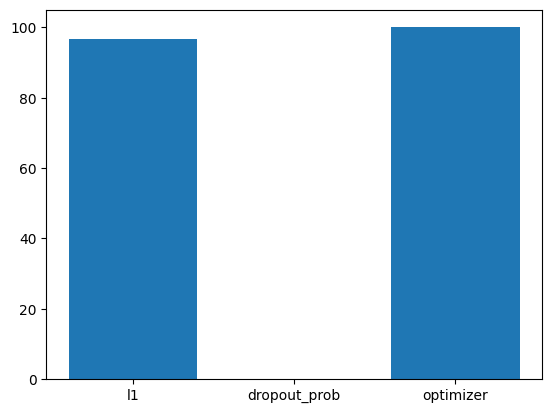

In [25]:
#| echo: true
spot_tuner.plot_importance(threshold=0.025, filename="./figures/" + experiment_name+"_importance.png")

![Variable importance](./figures/figures24-torch_bartz09_10min_20init_2023-06-06_22-50-23_importance.png){#fig-importance width="50%"}


## Get SPOT Results {#sec-get-spot-results}

The architecture of the `spotPython` model can be obtained by the following code:

In [26]:
#| echo: true
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_lin_reg(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=7.033278237589258e-09, inplace=False)
  (dropout2): Dropout(p=3.516639118794629e-09, inplace=False)
)

First, the numerical representation of the hyperparameters are obtained, i.e., the numpy array `X` is generated. This array is then used to generate the model `model_spot` by the function `get_one_core_model_from_X`. The model `model_spot` has the following architecture:


```{raw}
Net_lin_reg(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)
```


## Evaluation of the Tuned Architecture 

The method `train_tuned` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model weights are saved as a dictionary.

 The following code trains the model `model_spot`. If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be saved to this file.

In [27]:
#| echo: true
from spotPython.torch.traintest import (
    train_tuned,
    test_tuned,
    )
train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = DEVICE,
        path=None,
        task=fun_control["task"],)

Epoch: 1
Loss on hold-out set: 0.14248361388842265
MeanAbsoluteError value on hold-out data: 0.3374633491039276
Epoch: 2
Loss on hold-out set: 0.1346980706602335
MeanAbsoluteError value on hold-out data: 0.32663118839263916
Epoch: 3
Loss on hold-out set: 0.12712224694589774
MeanAbsoluteError value on hold-out data: 0.31575965881347656
Epoch: 4
Loss on hold-out set: 0.119890608638525
MeanAbsoluteError value on hold-out data: 0.3049975037574768
Epoch: 5
Loss on hold-out set: 0.11284715642531713
MeanAbsoluteError value on hold-out data: 0.29419058561325073
Epoch: 6
Loss on hold-out set: 0.10612999276568492
MeanAbsoluteError value on hold-out data: 0.28368911147117615
Epoch: 7
Loss on hold-out set: 0.09958385593568285
MeanAbsoluteError value on hold-out data: 0.2732113301753998
Epoch: 8
Loss on hold-out set: 0.09353287355353435
MeanAbsoluteError value on hold-out data: 0.263106107711792
Epoch: 9
Loss on hold-out set: 0.08763899924854437
MeanAbsoluteError value on hold-out data: 0.253176927

```{raw}
Epoch: 1
Loss on hold-out set: 0.17853929138431945
MeanAbsoluteError value on hold-out data: 0.3907899856567383
Epoch: 2
Loss on hold-out set: 0.17439044278115035
MeanAbsoluteError value on hold-out data: 0.38570401072502136
```

If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be loaded from this file.

In [28]:
#| echo: true
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = DEVICE,
            task=fun_control["task"],)

Loss on hold-out set: 2.818314775205571e-05
MeanAbsoluteError value on hold-out data: 0.00369589333422482
Final evaluation: Validation loss: 2.818314775205571e-05
Final evaluation: Validation metric: 0.00369589333422482
----------------------------------------------


(2.818314775205571e-05, nan, tensor(0.0037))

```{raw}
Loss on hold-out set: 1.85966069472272e-05
MeanAbsoluteError value on hold-out data: 0.0021022311411798
Final evaluation: Validation loss: 1.85966069472272e-05
Final evaluation: Validation metric: 0.0021022311411798
----------------------------------------------
(1.85966069472272e-05, nan, tensor(0.0021))
```

## Cross-validated Evaluations

In [29]:
from spotPython.torch.traintest import evaluate_cv
# modify k-kolds:
setattr(model_spot, "k_folds",  10)
evaluate_cv(net=model_spot,
            dataset=fun_control["data"],
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            task=fun_control["task"],
            writer=fun_control["writer"],
            writerId="model_spot_cv", device=DEVICE)

Fold: 1
Epoch: 1
Loss on hold-out set: 0.14901519656181336
MeanAbsoluteError value on hold-out data: 0.34210288524627686
Epoch: 2
Loss on hold-out set: 0.14053788006305695
MeanAbsoluteError value on hold-out data: 0.330159068107605
Epoch: 3
Loss on hold-out set: 0.13194559916853904
MeanAbsoluteError value on hold-out data: 0.31796544790267944
Epoch: 4
Loss on hold-out set: 0.12349418085068464
MeanAbsoluteError value on hold-out data: 0.3055115044116974
Epoch: 5
Loss on hold-out set: 0.1151967541873455
MeanAbsoluteError value on hold-out data: 0.2929932773113251
Epoch: 6
Loss on hold-out set: 0.10705217890441418
MeanAbsoluteError value on hold-out data: 0.2805975079536438
Epoch: 7
Loss on hold-out set: 0.09923803128302097
MeanAbsoluteError value on hold-out data: 0.26878228783607483
Epoch: 8
Loss on hold-out set: 0.09182500399649143
MeanAbsoluteError value on hold-out data: 0.25735288858413696
Epoch: 9
Loss on hold-out set: 0.0847846246510744
MeanAbsoluteError value on hold-out data: 0.

(2.839848938793921e-05, nan, tensor(0.0031))

```{raw}
Fold: 1
Epoch: 1
Loss on hold-out set: 0.36993918985128404
MeanAbsoluteError value on hold-out data: 0.5827060341835022
Epoch: 2
Loss on hold-out set: 0.3583159705996513

(0.0027241395250238156, nan, tensor(0.0147))
```


@tbl-comparison shows the loss and meric value (MAE) of the model with the tuned hyperparameters from SPOT.

| Model     |  Loss    | Metric (MAE) |
|:----------|--------:|---------:|
| `Validation` |1.8597e-05      | 0.0021    |
| `10-fold CV` | 0.00272        | 0.0147    | 
: Comparison of the loss and metric values. {#tbl-comparison}


## Detailed Hyperparameter Plots

The contour plot in this section visualize the interactions of the two most important hyperparameters, `l1`, and `epochs` of the surrogate model used to optimize the hyperparameters. Since some of these hyperparameters take fatorial or integer values, sometimes step-like fitness landcapes (or response surfaces) are generated.
SPOT draws the interactions of the main hyperparameters by default. It is also possible to visualize all interactions. For this, again refer to the notebook [@bart23e].

l1:  96.7125294935965
dropout_prob:  0.09358278710838076
optimizer:  100.0


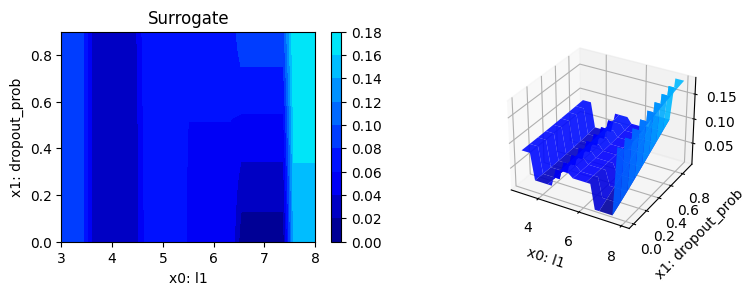

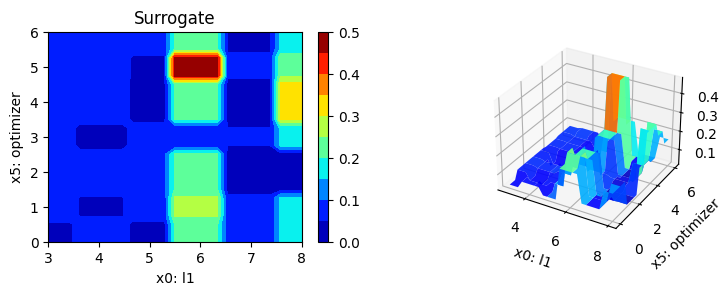

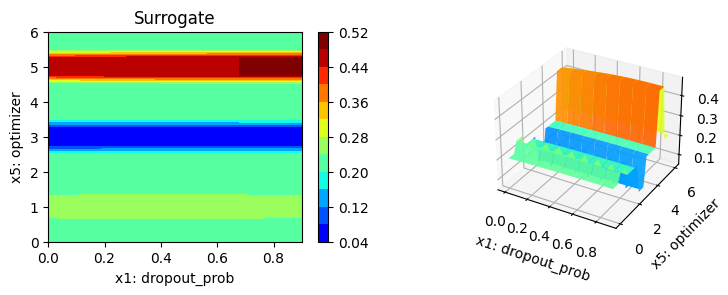

In [30]:
#| echo: true
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

![Contour plot of the loss as a function of `epochs` and `l1`, i.e., the number of neurons in the layers.](./figures/figures24-torch_bartz09_10min_20init_2023-06-06_22-50-23_contour_0_3.png){#fig-contour-0-3}


@fig-contour-0-3 shows a contour plot of the loss as a function of the hyperparameters. These plots are very helpful for benchmark studies and for understanding neural networks.
 `spotPython` provides additional tools for a visual inspection of the results and give valuable insights into the hyperparameter tuning process.
 This is especially useful for model explainability, transparency, and trustworthiness.
In addition to the contour plots, @fig-parallel shows the parallel plot of the hyperparameters.

In [31]:
#| echo: true
spot_tuner.parallel_plot()

![Parallel plot](./figures/figures24-torch_bartz09_10min_20init_2023-06-06_22-50-23_parallel.png){#fig-parallel}


# Summary and Outlook {#sec-summary}

This tutorial presents the hyperparameter tuning open source software `spotPython` for `PyTorch`.
Some of the advantages of `spotPython` are:

- Numerical and categorical hyperparameters.
- Powerful surrogate models.
- Flexible approach and easy to use.
- Simple JSON files for the specification of the hyperparameters.
- Extension of default and user specified network classes.
- Noise handling techniques.
- Online visualization of the hyperparameter tuning process with `tensorboard`.

Currently, only rudimentary parallel and distributed neural network training is possible, but these capabilities will be extended in the future. The next version of `spotPython` will also include a more detailed documentation and more examples.

::: {.callout-important}
Important: This tutorial does not present a complete benchmarking study [@bart20gArxiv]. The results are only preliminary and highly dependent on the local configuration (hard- and software). Our goal is to provide a first impression of the performance of the hyperparameter tuning package `spotPython`.  The results should be interpreted with care.
:::



{{< pagebreak >}}

# References {.unnumbered}

::: {#refs}
:::
